In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
plt.style.use(['science', 'grid'])

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *

%load_ext autoreload
%autoreload 2


In [3]:
# Generate a schedule...
h = 400
os.chdir("./exploration")
requests = load_worldcities(10000)
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 1, 13, 0, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
width=800
height=600

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

In [4]:
schedule = milp_schedule(accesses, requests, agility_bangbang)
# Calculate tasks/sec
tasks_per_sec = len(schedule) / (t_end - t0).total_seconds()
prob_task_good = 0.34

$$d = R \arccos\!\left(\frac{(R+h)\sin^2\theta + \cos\theta\,\sqrt{R^2 - (R+h)^2 \sin^2\theta}}{R}\right)$$


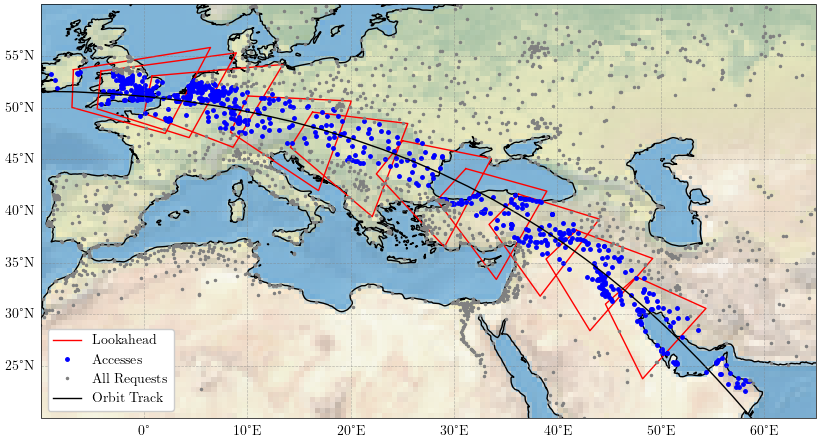

In [ ]:
def roll2crosstrack(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) *  R * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))

def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    
    beta = np.pi - np.arcsin((Constants.R_E + h)/(Constants.R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

# angle = -10
# print(roll2crosstrack(angle, orbit.a - Constants.R_E))
# print(Constants.R_E * subtending_angle_from_fov(np.deg2rad(angle), orbit.a - Constants.R_E))

def accesses2track(accesses, orbit, t0, t_end):
    v_orbit = v_orb(orbit.a - Constants.R_E)
    # Along, across...
    track = [(a.time - t0).total_seconds() * v_orbit for a in accesses]
    print([a.angle for a in accesses])
    roll2cr = [roll2crosstrack(a.angle, orbit.a - Constants.R_E) for a in accesses]
    
    return track, roll2cr

for a in accesses:
    a.state = {"observed": False}

K = get_intrinsics(800, width//2, height//2)

fig = plt.figure(figsize=(10, 10))
# Create a cartopy GeoAxes with PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())
lookahead_plotted=False
for i, s in enumerate(schedule):
    t = s.time
    # Convert all accesses to ECEF
    accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a) for a in accesses]
    # Get current orbit position in ECEF
    orbit_new = propagate_orbit(orbit, t)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, t)
    v_ecef = eci2ecef(v, t)
    # Filter by horizon
    accesses_filtered = [(r, a, t, access) for r, a, t, access in accesses_converted if t >= s.time and s.time <= t + datetime.timedelta(hours=1) and dist(pos_ecef, r) < horizon_distance(orbit) and a <= 30]
    points = np.array([r for r, _, _, _ in accesses_filtered])
    # Take the average
    average_vec = pos_ecef - (np.mean(points, axis=0))

    # Get the angle between that and nadir
    nadir = -pos_ecef/np.linalg.norm(pos_ecef)
    lookahead_angle = np.arccos(np.dot(-nadir, average_vec)/np.linalg.norm(average_vec))

    # Unproject test
    box = np.array([[0, 0], [width, 0], [width, height], [0, height], [0, 0]])
    
    # Step 1: Define the satellite’s local frame (body frame)
    # Up vector: from Earth's center to the satellite (nadir)
    Up = pos_ecef / np.linalg.norm(pos_ecef)

    # Initial along-track vector: direction of velocity
    Along = v_ecef / np.linalg.norm(v_ecef)

    # Right vector: perpendicular to both Along and Up
    Right = np.cross(Along, Up)
    Right = Right / np.linalg.norm(Right)

    # Recompute Along to ensure an orthonormal basis
    Along = np.cross(Up, Right)
    Along = Along / np.linalg.norm(Along)

    # Build the rotation matrix from ECEF to local (body) frame.
    # Rows of this matrix are the local axes in ECEF coordinates.
    R_ecef_to_body = np.vstack([Right, Along, Up])

    # Step 2: Express the average vector in the local coordinate system.
    # This transforms average_vec from ECEF to the body frame.
    v_local = R_ecef_to_body @ average_vec
    v_local_norm = v_local / np.linalg.norm(v_local)  # normalize for angle calculations

    # Step 3: Compute pitch and roll.
    # With our local frame [Right, Along, Up]:
    # - v_local[0] is the Right component,
    # - v_local[1] is the Along component,
    # - v_local[2] is the Up component.
    #
    # Define:
    #   pitch = arctan2(Along component, Up component)
    #   roll  = arctan2(Right component, Up component)
    pitch = -np.arctan2(v_local_norm[1], v_local_norm[2])
    roll  = -np.arctan2(v_local_norm[0], v_local_norm[2])

    # Optionally convert to degrees:
    # TODO: Fix sign
    pitch_deg = np.degrees(pitch) * 1
    roll_deg  = np.degrees(roll)


    pitch_deg = np.clip(pitch_deg, -30, 41)
    roll_deg = np.clip(roll_deg, -30, 30)


    # First, project and see if it's in the box
    points_eci = np.array([ecef2eci(p, t) for p in points])
    ecef_projected_dir = project_from_orbit(points_eci, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg)
    # Figure out how many are in the box
    in_box_idx = np.array([i for i, p in enumerate(ecef_projected_dir) if p[0] >= 0 and p[0] <= width and p[1] >= 0 and p[1] <= height])
    not_observed = np.array([not accesses_filtered[i][-1].state["observed"] for i in in_box_idx]).astype(int)

    total_unobserved_inbox = np.sum(not_observed)
    lookahead_reward = total_unobserved_inbox * 1

    # take_lookahead = True
    take_lookahead = lookahead_reward >= 30

    # Take the lookahead only if..
    # tasks in box * probability they are available / (2 * angle * (angle_per_task) >= average reward per task
    take_lookahead = (total_unobserved_inbox * (1 - prob_task_good) * tasks_per_sec * 100) - (prob_task_good) * len([x for x in accesses_filtered if (x[-1].time - t).total_seconds() <= (2 * (agility_bangbang(np.degrees(lookahead_angle)) - t_s))]) >= 15
    # print(take_lookahead)
    if(take_lookahead):
        for i in in_box_idx:
            accesses_filtered[i][-1].state["observed"] = True


    # Projections
    # plt.plot([a[0] for a in ecef_projected_dir], [a[1] for a in ecef_projected_dir], 'g.')
    # Plot box
    # plt.plot([a[0] for a in box], [a[1] for a in box], 'b')
    # plt.show()

    # For plotting
    ecef_unprojected_dir = -(r - unproject_from_orbit(box, 1, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg))
    # Calculate Earth line intersections in ECI
    
    eci_intersections = [earth_line_intersection(r, d)[0] for d in ecef_unprojected_dir]
    # Convert to latlong
    latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]

    
    # Plot
    if(take_lookahead):
        plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label='Lookahead' if not lookahead_plotted else None)
        lookahead_plotted = True

    # plt.plot([a.long for a in accesses if a.state["observed"]], [a.lat for a in accesses if a.state["observed"]], 'g.')

    # plt.plot([a.long for a in accesses if not a.state["observed"]], [a.lat for a in accesses if not a.state["observed"]], 'r.')
    # plt.show()

# Plot accesses
plt.plot([a.long for a in accesses], [a.lat for a in accesses], 'b.', transform=ccrs.PlateCarree(), label='Accesses', markersize=5)
plt.plot([r.long for r in requests if r not in [x.request for x in accesses]], [r.lat for r in requests if r not in [x.request for x in accesses]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong = [kepler2latlong(propagate_orbit(orbit, t), orbit.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong], [lat for lat, long in orbit_latlong], 'k-', label='Orbit Track')

# Add coastlines
ax.stock_img()
ax.coastlines()
ax.set_extent([-10, 65, 20, 60], crs=ccrs.PlateCarree())
ax.legend(frameon=True)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.show()